In [92]:
from pkg_resources import resource_filename
import pandas as pd
import numpy as np
import qupid
import os

In [93]:
# loads in data and reads data- change to file path
#os.getcwd()
#metadata_fpath = resource_filename("qupid", "asd.tsv")
# metadata_fpath = "asd.tsv"
# metadata = pd.read_table(metadata_fpath, sep="\t", index_col=0)

In [94]:
metadata_fpath = "sample_information_from_prep_1115.tsv"
metadata_pre = pd.read_table(metadata_fpath, sep="\t", index_col=0)

In [95]:
metadata = metadata_pre.drop(metadata_pre[metadata_pre['cat'] == 'not provided'].index)
metadata.head()

,asd,bmi,cat,dog,ibd,ibs,pku,sex,diet,race,...,pm_shared_who_posteddiscussed_on_an_online_patienthealth_platform_ie_patientslikeme,covid_family_members_put_into_self_quarantine_without_symptoms_eg_due_to_possible_exposure,covid_happened_to_you_put_into_self_quarantine_without_symptoms_eg_due_to_possible_exposure,pm_shared_pcp_changes_what_change_in_behaviorallifestyle_recommendations_eg_start_probiotic,pm_lifestyle_change_how_change_in_alcohol_or_tobacco_use_ie_starting_stopping_or_changing_amount_consumed,pm_shared_pcp_changes_what_change_in_medication_ie_starting_stopping_or_changing_the_dose_of_a_prescription,pm_lifestyle_change_how_change_in_physical_environment_ie_adopting_or_getting_rid_of_a_pet_cleaning_more_or_less_often,name,keep_sample_for_thdmi,qiita_study_id
sample_name,,,,,,,,,,,,,,,,,,,,,
10317.000001002,not provided,NaN,No,No,not provided,not provided,I do not have this condition,female,NaN,not provided,...,NaN,false,false,NaN,NaN,NaN,NaN,NaN,NaN,10317
10317.000001004,not provided,NaN,No,No,I do not have this condition,not provided,I do not have this condition,female,NaN,Caucasian,...,NaN,false,false,NaN,NaN,NaN,NaN,NaN,NaN,10317
10317.000001008,not provided,NaN,No,Yes,I do not have this condition,not provided,I do not have this condition,female,NaN,Caucasian,...,NaN,false,false,NaN,NaN,NaN,NaN,NaN,NaN,10317
10317.000001018,not provided,NaN,No,No,I do not have this condition,not provided,I do not have this condition,male,NaN,Caucasian,...,NaN,false,false,NaN,NaN,NaN,NaN,NaN,NaN,10317
10317.000001028,not provided,NaN,No,Yes,I do not have this condition,not provided,I do not have this condition,female,not applicable,Caucasian,...,NaN,false,false,NaN,NaN,NaN,NaN,NaN,NaN,10317


In [96]:
# asd_str = "Diagnosed by a medical professional (doctor, physician assistant)"
# no_asd_str = "I do not have this condition"

# background = metadata.query("asd == @no_asd_str")
# focus = metadata.query("asd == @asd_str")


In [97]:
asd_str = "Yes"
no_asd_str = "No"

background = metadata.query("cat == @no_asd_str")
focus = metadata.query("cat == @asd_str")


In [103]:

matches = qupid.shuffle(
    focus=focus,
    background=background,
    # categories=["sex", "age_years"],
    # tolerance_map={"age_years": 10},
    categories=["sex"],
    iterations=100
)

/opt/homebrew/Caskroom/miniconda/base/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/qupid/qupid.py:49: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for f_idx, f_val in focus.iteritems():


In [119]:
from qupid import match_by_single
cm = match_by_multiple(
    focus=focus,
    background=background,
    categories=["sex"]
)

/opt/homebrew/Caskroom/miniconda/base/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/qupid/qupid.py:49: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for f_idx, f_val in focus.iteritems():


In [131]:
from typing import List
from qupid import CaseMatchOneToMany

def random_match(
    focus: pd.DataFrame,
    background: pd.DataFrame,
    categories: List[str]
) -> CaseMatchOneToMany:
    """Randomly match samples from focus to background.

    :param focus: Samples to be matched
    :type focus: pd.DataFrame

    :param background: Metadata to match against
    :type background: pd.DataFrame

    :param categories: Categories to include as matching criteria
    :type categories: List[str]

    :returns: Randomly matched control samples
    :rtype: qupid.CaseMatchOneToMany
    """
    matches = {i: set() for i in focus.index}

    for cat in categories:
        focus_idx = focus.index.tolist()
        np.random.shuffle(focus_idx)
        for idx in focus_idx:
            match_idx = np.random.choice(background.index)
            matches[idx].add(match_idx)

    metadata = pd.concat([focus, background])
    return CaseMatchOneToMany(matches, metadata)

In [133]:
from qupid import CaseMatchOneToOne
from typing import List, Dict, Union

def random_match_one_to_one(
    focus: pd.DataFrame,
    background: pd.DataFrame,
    categories: List[str]
) -> CaseMatchOneToOne:
    """Randomly match samples from focus to background in a one-to-one manner.

    :param focus: Samples to be matched
    :type focus: pd.DataFrame

    :param background: Metadata to match against
    :type background: pd.DataFrame

    :param categories: Categories to include as matching criteria
    :type categories: List[str]

    :returns: Randomly matched control samples
    :rtype: qupid.CaseMatchOneToOne
    """
    matches = {}

    for cat in categories:
        focus_idx = focus.index.tolist()
        np.random.shuffle(focus_idx)
        for idx in focus_idx:
            match_idx = np.random.choice(background.index)
            matches[idx] = {match_idx}
            background = background.drop(match_idx)

    metadata = pd.concat([focus, background])
    return CaseMatchOneToOne(matches, metadata)

# Example usage:
# matched_samples = random_match_one_to_one(focus_df, background_df, ['category1', 'category2'])

In [132]:
rm = random_match(
    focus=focus,
    background=background,
    categories=["sex"]
)

In [134]:
rm = random_match_one_to_one(
    focus=focus,
    background=background,
    categories=["sex"]
)

In [122]:
# def random_match_table(table, match_column):
#     # Separate rows with 'yes' and 'no'
#     yes_rows = table[table[match_column] == 'Diagnosed by a medical professional (doctor, physician assistant)']
#     no_rows = table[table[match_column] == 'I do not have this condition']

#     # Check if there are at least one 'yes' and one 'no'
#     if yes_rows.empty or no_rows.empty:
#         raise ValueError("Insufficient rows with 'yes' or 'no' for matching.")

#     # Shuffle the order of rows with 'yes' and 'no'
#     yes_rows = yes_rows.sample(frac=1, random_state=42)
#     no_rows = no_rows.sample(frac=1, random_state=42)

#     # Create a DataFrame to store matched pairs
#     matched_pairs = pd.DataFrame()

#     # Iterate through each 'yes' row and match with a random 'no' row
#     for _, yes_row in yes_rows.iterrows():
#         matched_no_row = no_rows.sample(n=1).iloc[0]
#         matched_pair = pd.concat([yes_row, matched_no_row])
#         matched_pairs = matched_pairs.append(matched_pair, ignore_index=True)

#     return matched_pairs

# # Example usage:
# # Assuming 'your_table.csv' is your table with a 'match_column'
# # Replace it with the actual name of your file and column
# your_table = pd.read_csv(metadata_fpath, sep="\t", index_col=0)
# matched_pairs = random_match_table(your_table, 'asd')

# # Access the matched pairs DataFrame
# # print(matched_pairs)


In [135]:
print(len(cm.cases), len(cm.controls))
print(len(rm.cases), len(rm.controls))

147 281
147 147


In [136]:
#matched pairs only for onetomany
resultsc = cm.create_matched_pairs(iterations=100)
resultsr = rm.create_matched_pairs(iterations=100)

AttributeError: 'CaseMatchOneToOne' object has no attribute 'create_matched_pairs'

In [137]:
print(len(resultsc[0].cases), len(resultsc[0].controls))
print(len(resultsr[0].cases), len(resultsr[0].controls))

147 147
147 147


In [138]:
resultsc_df = resultsc.to_dataframe()
resultsc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
case_id,,,,,,,,,,,,,,,,,,,,,
10317.000002683,10317.000002396,10317.000003969,10317.000001151,10317.000003971,10317.000002637,10317.000001802,10317.000001275,10317.000003282,10317.000001978,10317.000003937,...,10317.000002502,10317.000003300,10317.000001180,10317.000003282,10317.000001747,10317.000002819,10317.000003103,10317.000001275,10317.000001174,10317.000002322
10317.000001299,10317.000001870,10317.000001097,10317.000002625,10317.000001305,10317.000001870,10317.000003458,10317.000001049,10317.000002387,10317.000002616,10317.000002274,...,10317.000002943,10317.000001098,10317.000001282,10317.000001221,10317.000001661,10317.000002205,10317.000001745,10317.000003216,10317.000002625,10317.000001171
10317.000001446,10317.000001528,10317.000002834,10317.000001504,10317.000001543,10317.000001548,10317.000001097,10317.000001678,10317.000002739,10317.000001772,10317.000001585,...,10317.000002273,10317.000001559,10317.000001874,10317.000001531,10317.000001519,10317.000001745,10317.000003970,10317.000001528,10317.000001548,10317.000003970
10317.000001216,10317.000003640,10317.000001955,10317.000001449,10317.000001980,10317.000001504,10317.000001531,10317.000001173,10317.000001694,10317.000001650,10317.000001345,...,10317.000001528,10317.000002173,10317.000001585,10317.000001749,10317.000001008,10317.000001660,10317.000001519,10317.000002205,10317.000002736,10317.000001312
10317.000002886,10317.000002619,10317.000003103,10317.000002321,10317.000002350,10317.000001978,10317.000003300,10317.000001595,10317.000003507,10317.000001294,10317.000002944,...,10317.000001540,10317.000003060,10317.000001110,10317.000001110,10317.000001711,10317.000001797,10317.000001830,10317.000001399,10317.000003971,10317.000001540


In [127]:
resultsr_df = resultsr.to_dataframe()
resultsr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
case_id,,,,,,,,,,,,,,,,,,,,,
10317.000002683,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,...,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282,10317.000001282
10317.000001299,10317.000001322,10317.000001322,10317.000002819,10317.000001322,10317.000002819,10317.000001322,10317.000002819,10317.000001322,10317.000001322,10317.000002819,...,10317.000002819,10317.000002819,10317.000002819,10317.000002819,10317.000002819,10317.000002819,10317.000002819,10317.000001322,10317.000002819,10317.000002819
10317.000001446,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,...,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850,10317.000002850
10317.000001216,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002849,10317.000002606,10317.000002606,...,10317.000002849,10317.000002849,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606,10317.000002606
10317.000002886,10317.000002943,10317.000002943,10317.000004207,10317.000004207,10317.000004207,10317.000004207,10317.000004207,10317.000004207,10317.000004207,10317.000002943,...,10317.000004207,10317.000002943,10317.000002943,10317.000004207,10317.000004207,10317.000002943,10317.000004207,10317.000002943,10317.000002943,10317.000002943


In [128]:
rng = np.random.default_rng()
asd_mean = 4
ctrl_mean = 3.75

num_cases = len(cm.cases)
num_ctrls = len(cm.controls)

asd_values = rng.normal(asd_mean, 1, size=num_cases)
ctrl_values = rng.normal(ctrl_mean, 1, size=num_ctrls)
print(asd_values[:])

asd_values = pd.Series(asd_values, index=focus.index)
ctrl_values = pd.Series(ctrl_values, index=background.index)

print(asd_values.head())

sample_values = pd.concat([asd_values, ctrl_values])

[4.78630468 3.48230072 3.93486243 3.18195939 3.8797472  4.71754663
 4.4082639  4.49111443 3.22208853 4.85231358 3.36128533 3.65901676
 3.68047976 4.05949975 4.74536981 3.91924625 4.99972784 3.6164174
 2.1052263  4.01598698 4.70230683 4.09662107 2.74196175 3.90931804
 5.06962311 3.45647644 5.65896325 6.82598252 3.45153357 5.76777239
 4.97562605 3.90677911 4.67212265 3.06025135 3.12354067 4.01523402
 3.8806915  3.88374093 3.43632946 3.50558591 4.06498242 4.29181877
 2.13033687 4.31394771 3.82929183 4.98424683 4.06073187 3.51707754
 3.73890567 4.35442154 3.14686784 3.60807401 3.31874911 4.82244791
 3.51137266 4.23624402 3.77362051 3.76641783 2.78531568 4.28631212
 3.4661677  4.69161858 3.99738161 6.17735771 2.01539333 3.85883296
 5.02612713 3.3547816  4.43812087 3.16892275 5.15706288 4.02965457
 4.15638057 5.83255622 2.22792185 4.31659784 4.72327174 4.19300003
 2.15952419 3.98407594 3.45152751 1.83605732 4.85128834 1.92817124
 5.05266286 4.17335196 3.98316097 4.3537084  3.76036435 2.78364

In [129]:
from qupid.stats import bulk_univariate_test

test_results = bulk_univariate_test(
    casematches=resultsc,
    values=sample_values,
    test="t"
)

In [130]:
print(test_results.head())

   method_name test_statistic_name  test_statistic   p-value  sample_size  \
50      t-test                   t        3.850911  0.000145          294   
26      t-test                   t        3.590867  0.000387          294   
18      t-test                   t        3.434356  0.000680          294   
11      t-test                   t        3.354885  0.000899          294   
94      t-test                   t        3.299610  0.001088          294   

    number_of_groups  
50                 2  
26                 2  
18                 2  
11                 2  
94                 2  


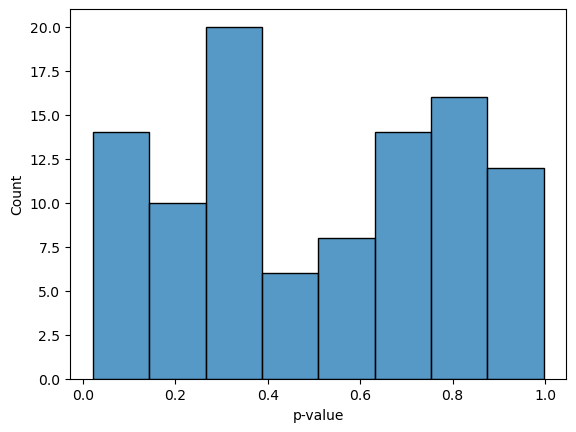

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.histplot(test_results["p-value"])

plt.show()

In [26]:

from qupid.casematch import CaseMatchOneToMany, CaseMatchOneToOne, CaseMatchCollection

cm.save("asd_matches.one_to_many.json")  # Save all possible matches
results.save("asd_matches.100.tsv")  # Save all 100 iterations
results[15].save("asd_matches.best.json")  # Save best matching

CaseMatchOneToMany.load("asd_matches.one_to_many.json")
CaseMatchCollection.load("asd_matches.100.tsv")
CaseMatchOneToOne.load("asd_matches.best.json")